1. Выбрать и обосновать метрику для измерения качества 
В даннном проекте решается задача регрессии. В качестве метрик для наглядности используются 3 основные метрики, MSE, RMSE, R2, которые считаются в отдельной функции.
При подборе гиперпараметров с помощью GridSearchCV используется R2, минимизация которой дает более точный результат, поскольку в начале я решила не обрабатывать выбросы, а MSE метрика сильно влияет на величину ошибки при сильном отклонении от целевой переменной от истинного значения
2. Провести EDA на своих данных 
Построение графиков зависимости целевой переменной от количественных признаков показало, что в принципе, облаки значений многих признаков вытягиваются вдоль каких-то прямых, следовательно, целесообразно попробовать применить линейную регрессию.
Построение boxplot для качественных признаков позволило выявить некоторые выбросы в данных, но поскольку модель дала в результате хорошее качество и без обработки выбросов, решила оставить данные, как есть.


In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [7]:
# 2 заимствованных метода
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig('report.png')
    plt.show()
    
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [33]:
df_train = reduce_mem_usage(pd.read_csv("train.csv"))
df_test = reduce_mem_usage(pd.read_csv("test.csv"))

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 0.0%


C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in longlong_scalars


Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 0.0%


# Просмотрим основную информацию о данных

In [9]:
df_train.head(30)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [10]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049957,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685265,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284721,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066681,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int16
MSSubClass       1460 non-null int16
MSZoning         1460 non-null category
LotFrontage      1201 non-null float32
LotArea          1460 non-null int32
Street           1460 non-null category
Alley            91 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null int8
OverallCond      1460 non-null int8
YearBuilt        1460 non-null int16
YearRemodAdd     1460 non-null int16
RoofStyle        1460 non-null category
RoofMatl         1460 non-null category

# Обработаем пропуски

In [18]:
def fillna_by_mode(df_train, df_test):
    max_row=len(df_train)
    for name, values in df_train.iteritems():
        k=df_train[name].isna().sum()
        # Столбцы, где очень мало значений, удаляем из основного датасета
        if k > (max_row // 2):
            df_train.drop(name, inplace=True, axis=1)
        elif k>0:         
            mode=df_train[name].mode()[0]
            df_train[name].fillna(value=mode, inplace=True)
            
    for name, values in df_test.iteritems():
        k=df_test[name].isna().sum()
        if k > (max_row // 2):
            df_test.drop(name, inplace=True, axis=1)
            
        elif k>0:       
            mode=df_train[name].mode()[0]
            df_test[name].fillna(value=mode, inplace=True)
            
        
    return (df_train, df_test)

In [34]:
data, data_test=fillna_by_mode(df_train, df_test)

In [35]:
data.drop('Id', inplace=True, axis=1)
data_test.drop('Id', inplace=True, axis=1)

In [32]:
data_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,...,82,0,0,144,0,0,1,2010,WD,Normal


# Выделяем числовые признаки, категориальные, отделяем целевую переменную

In [36]:
obj_data_names=data.select_dtypes(include='category').columns.tolist()
len(obj_data_names)

39

In [37]:
target=data['SalePrice']
target

0       208500
1       181500
2       223500
3       140000
4       250000
5       143000
6       307000
7       200000
8       129900
9       118000
10      129500
11      345000
12      144000
13      279500
14      157000
15      132000
16      149000
17       90000
18      159000
19      139000
20      325300
21      139400
22      230000
23      129900
24      154000
25      256300
26      134800
27      306000
28      207500
29       68500
         ...  
1430    192140
1431    143750
1432     64500
1433    186500
1434    160000
1435    174000
1436    120500
1437    394617
1438    149700
1439    197000
1440    191000
1441    149300
1442    310000
1443    121000
1444    179600
1445    129000
1446    157900
1447    240000
1448    112000
1449     92000
1450    136000
1451    287090
1452    145000
1453     84500
1454    185000
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int32

In [38]:
data.drop('SalePrice', inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
MSSubClass       1460 non-null int16
MSZoning         1460 non-null category
LotFrontage      1460 non-null float32
LotArea          1460 non-null int32
Street           1460 non-null category
LotShape         1460 non-null category
LandContour      1460 non-null category
Utilities        1460 non-null category
LotConfig        1460 non-null category
LandSlope        1460 non-null category
Neighborhood     1460 non-null category
Condition1       1460 non-null category
Condition2       1460 non-null category
BldgType         1460 non-null category
HouseStyle       1460 non-null category
OverallQual      1460 non-null int8
OverallCond      1460 non-null int8
YearBuilt        1460 non-null int16
YearRemodAdd     1460 non-null int16
RoofStyle        1460 non-null category
RoofMatl         1460 non-null category
Exterior1st      1460 non-null category
Exterior2nd      1460 non-null cat

In [39]:
num_data_names=data.select_dtypes(exclude='category').columns.tolist()
len(num_data_names)

36

# Построим матрицу корреляций и графики

In [26]:
data.shape

(1460, 75)

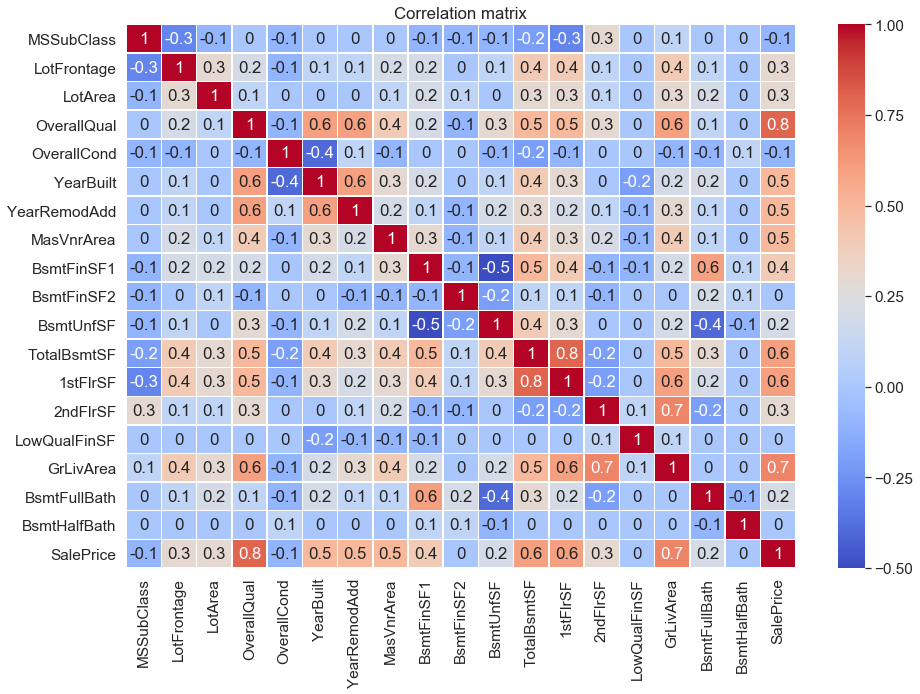

In [27]:
df_1=data[num_data_names[:18]].copy()
df_1['SalePrice']=target

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_1.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix.shape

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()



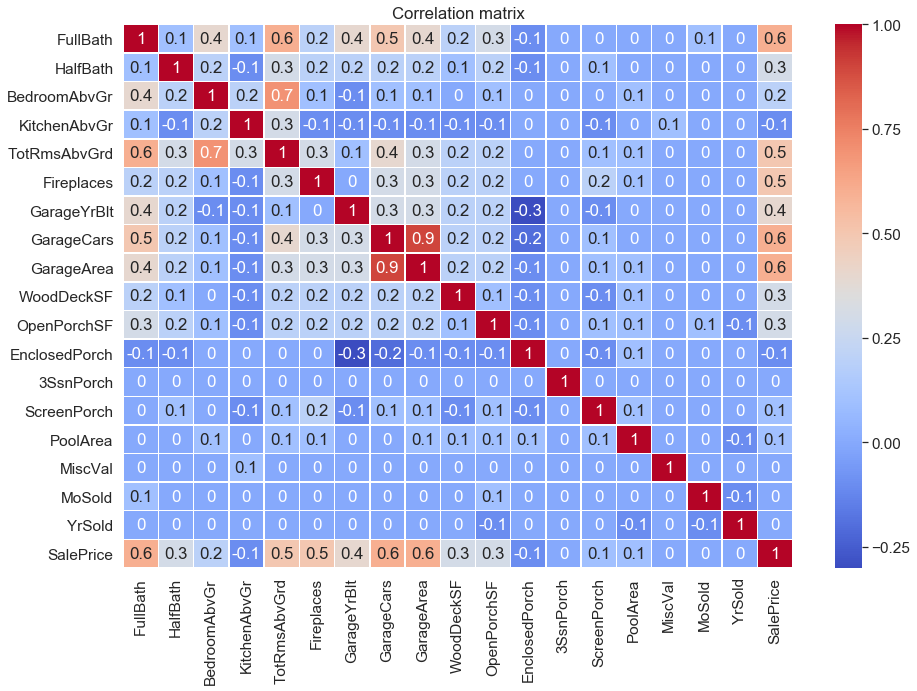

In [28]:
df_2=data[num_data_names[18:]].copy()
df_2['SalePrice']=target

plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_2.corr()
corr_matrix = np.round(corr_matrix, 1)
corr_matrix.shape

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()


In [29]:
len(num_data_names)

36

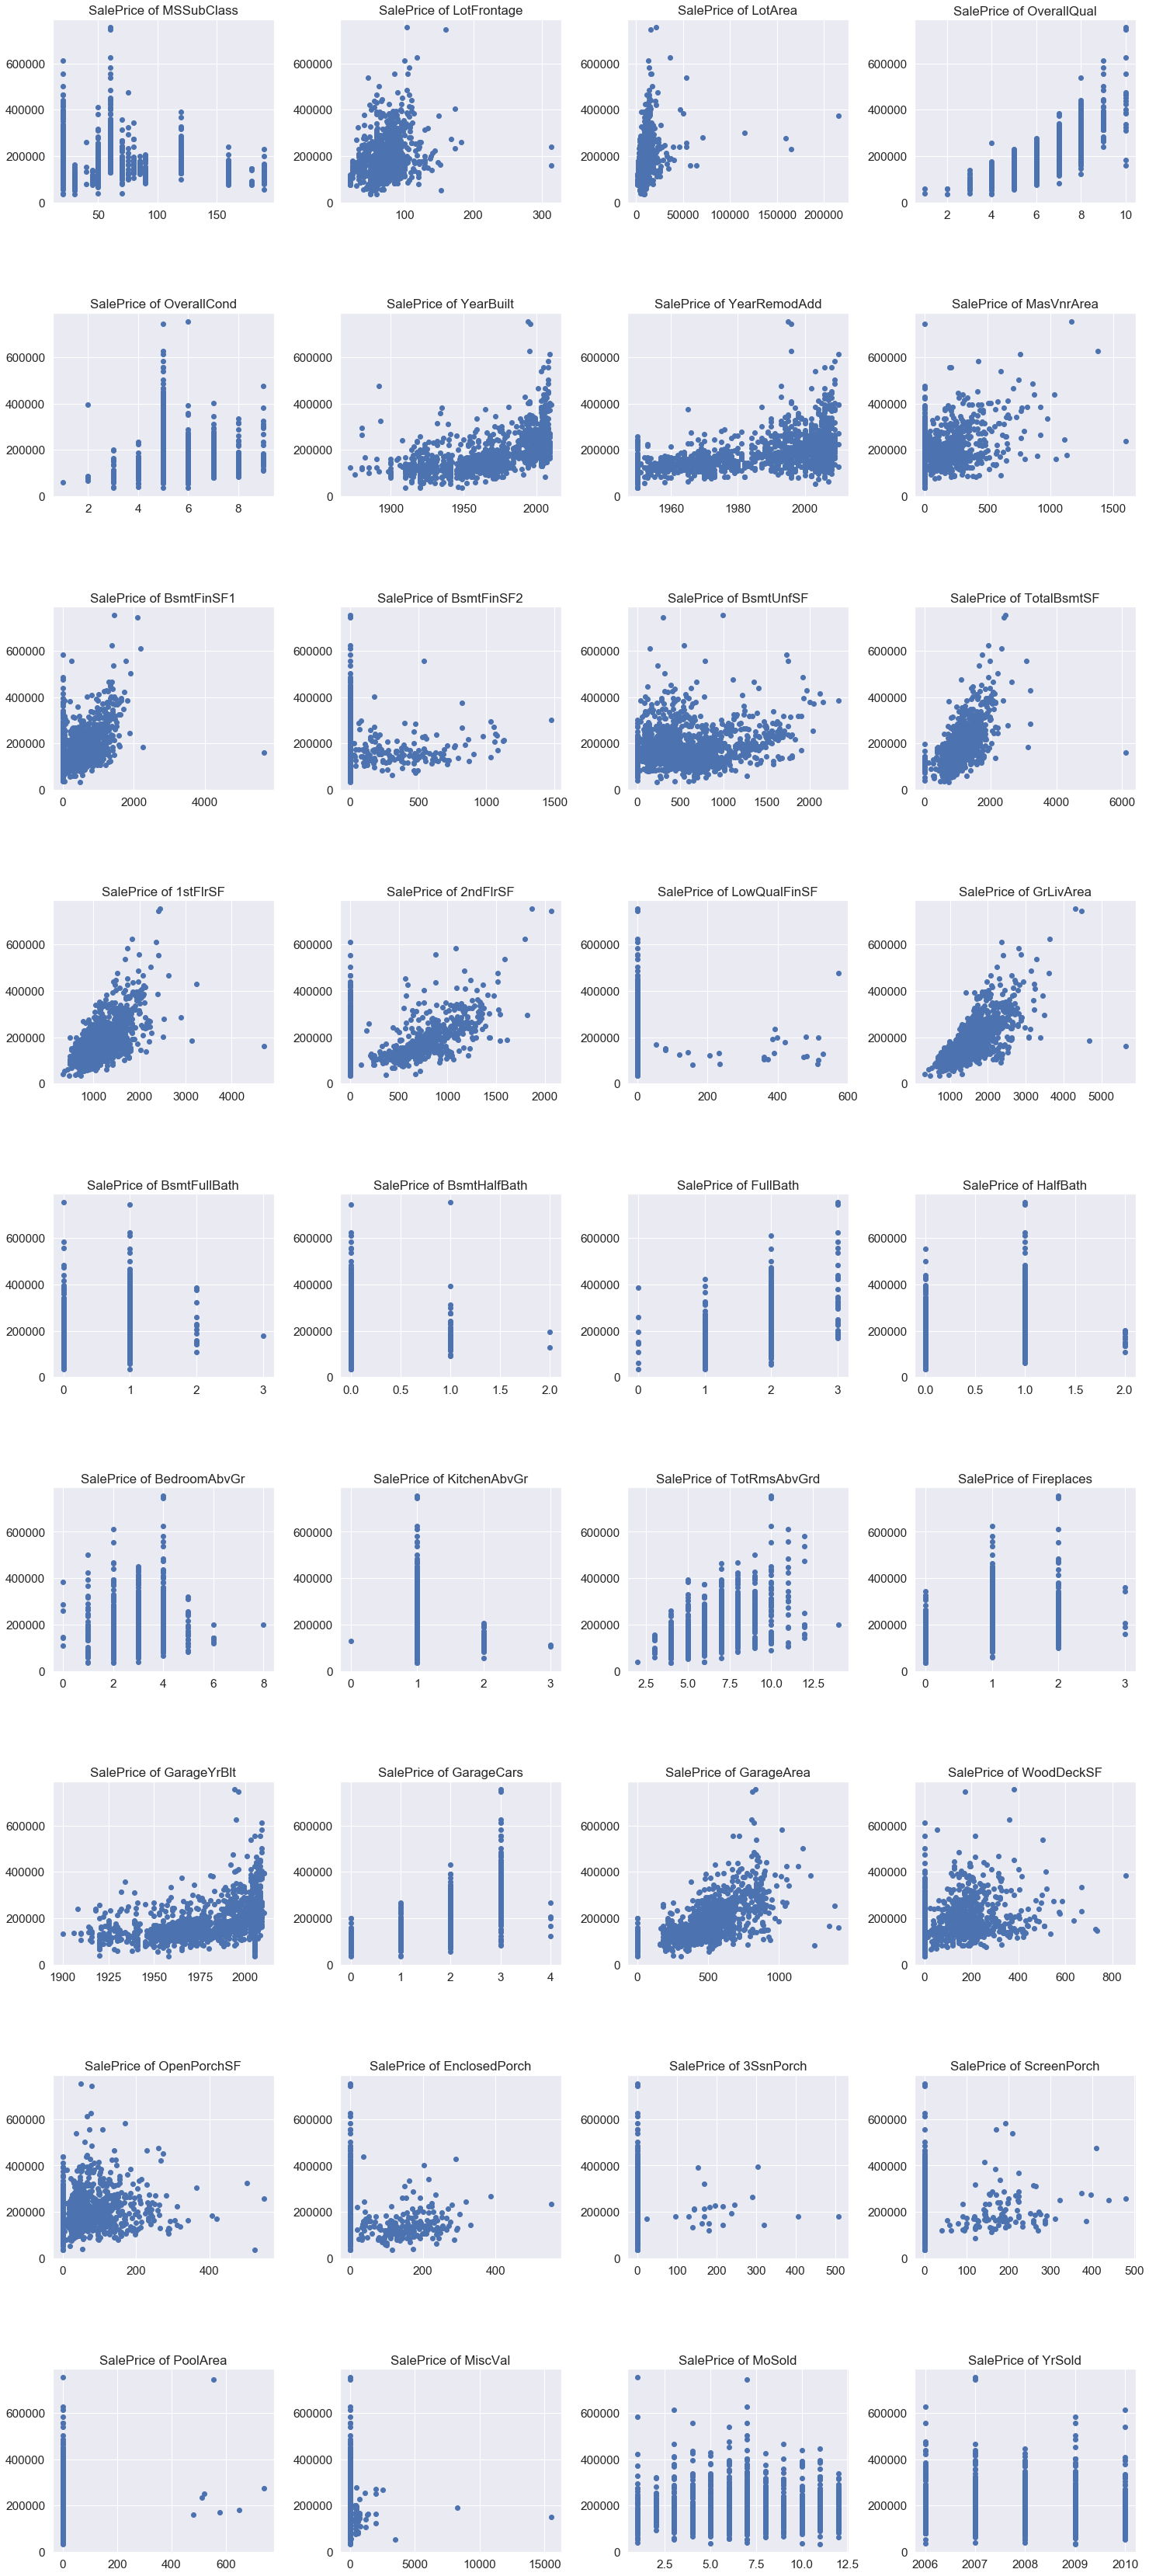

In [30]:
fig, axes = plt.subplots(nrows=9, ncols=4, figsize=(25, 60))
fig.subplots_adjust(wspace=0.3, hspace=0.6)

n=len(num_data_names)
count=0
for row in range(9):
    for j in range(4):
        axes[row,j].scatter(data[num_data_names[count]], target)
        axes[row,j].set_title("SalePrice of "+num_data_names[count])
        count+=1
        


# Переведем категориальные признаки в числовые

In [40]:
labelencoder = LabelEncoder()
for o in obj_data_names:
    data[o] = labelencoder.fit_transform(data[o])
    data_test[o]=labelencoder.transform(data_test[o])
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
MSSubClass       1460 non-null int16
MSZoning         1460 non-null int32
LotFrontage      1460 non-null float32
LotArea          1460 non-null int32
Street           1460 non-null int32
LotShape         1460 non-null int32
LandContour      1460 non-null int32
Utilities        1460 non-null int32
LotConfig        1460 non-null int32
LandSlope        1460 non-null int32
Neighborhood     1460 non-null int32
Condition1       1460 non-null int32
Condition2       1460 non-null int32
BldgType         1460 non-null int32
HouseStyle       1460 non-null int32
OverallQual      1460 non-null int8
OverallCond      1460 non-null int8
YearBuilt        1460 non-null int16
YearRemodAdd     1460 non-null int16
RoofStyle        1460 non-null int32
RoofMatl         1460 non-null int32
Exterior1st      1460 non-null int32
Exterior2nd      1460 non-null int32
MasVnrType       1460 non-null int32
MasVn

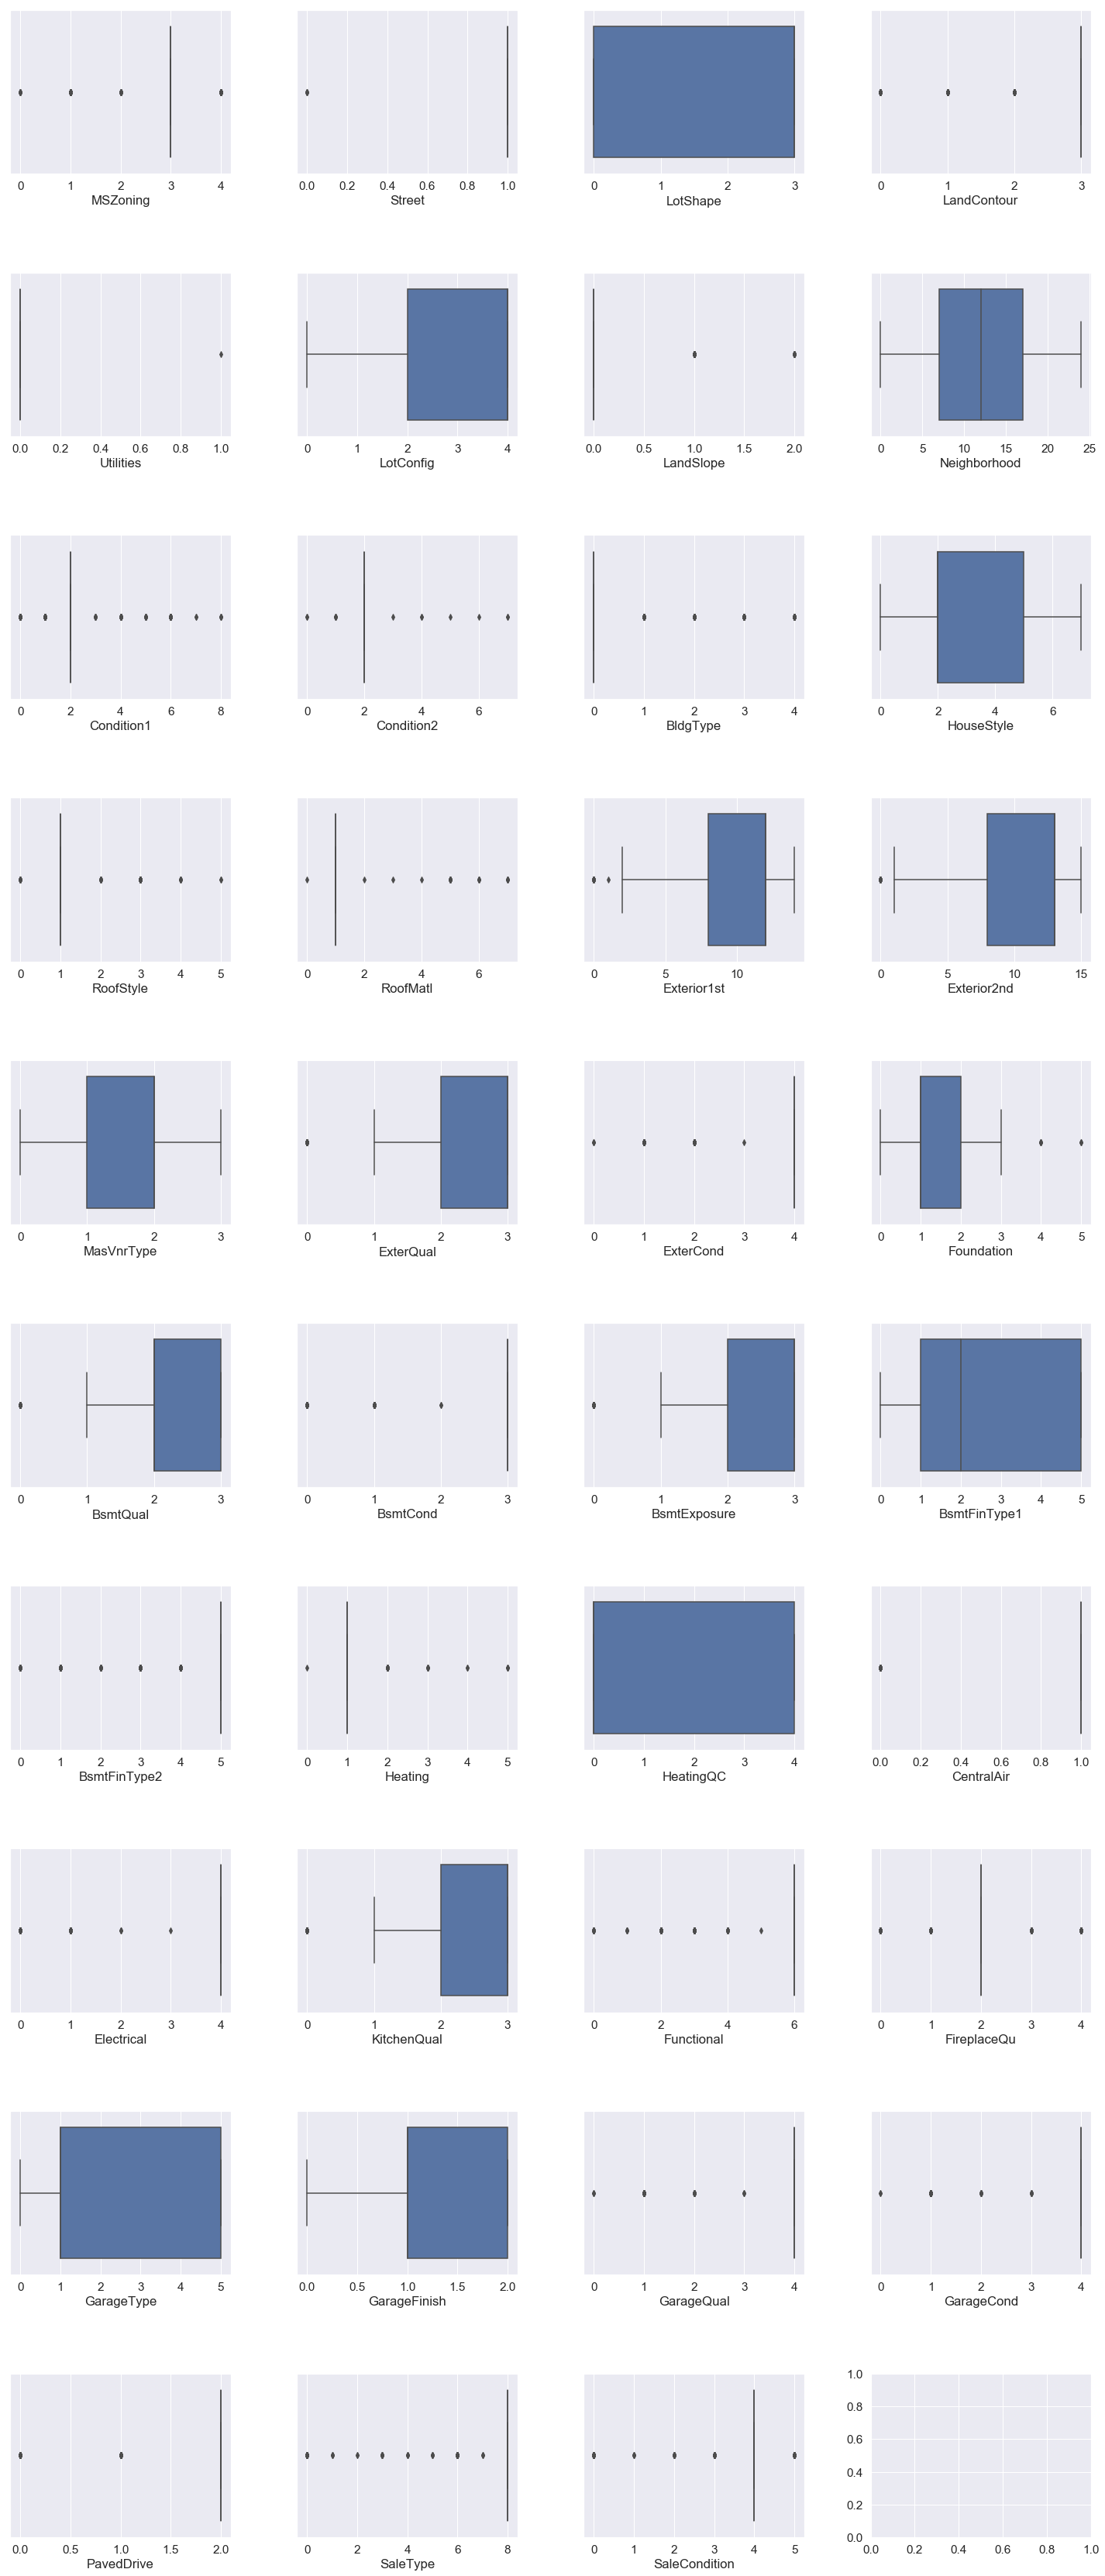

In [41]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(25, 60))
fig.subplots_adjust(wspace=0.3, hspace=0.6)

n=len(obj_data_names)
count=0
for row in range(10):
    for j in range(4):
        if count < n:
            sns.boxplot(x=data[obj_data_names[count]], ax=axes[row,j])
            count+=1

In [42]:
pd.set_option('display.max_columns', None)
data.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,3.028767,68.267120,10516.828082,0.995890,1.942466,2.777397,0.000685,3.019178,0.062329,12.251370,2.031507,2.008219,0.493151,3.038356,6.099315,5.575342,1971.267808,1984.865753,1.410274,1.075342,9.624658,10.339726,1.762329,103.117126,2.539726,3.733562,1.396575,2.280137,2.817123,2.284247,2.789726,443.639726,4.715753,46.549315,567.240411,1057.429452,1.036301,1.538356,0.934932,3.682192,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,2.339726,6.517808,5.749315,0.613014,2.386986,2.208219,1979.976074,1.228767,1.767123,472.980137,3.871918,3.905479,1.856164,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,7.513014,3.770548
std,42.300571,0.632017,22.356401,9981.264932,0.063996,1.409156,0.707666,0.026171,1.622634,0.276232,6.013735,0.868515,0.259040,1.198277,1.911305,1.382997,1.112799,30.202904,20.645407,0.834998,0.599127,3.197659,3.540570,0.614274,180.731125,0.693995,0.731807,0.722394,0.864510,0.650919,1.138472,1.837550,456.098091,0.925252,161.319273,441.866955,438.705324,0.295124,1.739524,0.246731,1.051301,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,0.830161,1.625393,0.979659,0.644666,0.900214,1.759864,24.749685,0.811835,0.747315,213.804841,0.594151,0.508297,0.496592,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,1.552100,1.100854
min,20.000000,0.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000,0.000000
25%,20.000000,3.000000,60.000000,7553.500000,1.000000,0.000000,3.000000,0.000000,2.000000,0.000000,7.000000,2.000000,2.000000,0.000000,2.00000

In [43]:
num_data_names.remove('YearBuilt')
num_data_names.remove('YearRemodAdd')
num_data_names

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [44]:
scaler = StandardScaler()
data[num_data_names] = scaler.fit_transform(data[num_data_names])
data

C:\Users\Admin\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int16, float32, int32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Admin\Anaconda2\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int8, int16, float32, int32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073375,3,-0.146189,-0.207142,1,3,3,0,4,0,5,2,2,0,5,0.651479,-0.517200,2003,2003,1,1,12,13,1,0.514104,2,4,2,2,3,3,2,0.575425,5,-0.288653,-0.944591,-0.459303,1,0,1,4,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,0.912210,6,-0.951226,2,1,0.930592,1,0.311725,0.351000,4,4,2,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,8,4
1,-0.872563,3,0.524992,-0.091886,1,3,3,0,2,0,24,1,2,0,2,-0.071836,2.179628,1976,1976,1,1,8,8,2,-0.570750,3,4,1,2,3,1,0,1.171992,5,-0.288653,-0.641228,0.466465,1,0,1,4,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,3,-0.318683,6,0.600495,4,1,-0.160705,1,0.311725,-0.060731,4,4,2,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,8,4
2,0.073375,3,-0.011953,0.073480,1,0,3,0,4,0,5,2,2,0,5,0.651479,-0.517200,2001,2002,1,1,12,13,1,0.325915,2,4,2,2,3,2,2,0.092907,5,-0.288653,-0.301643,-0.313369,1,0,1,4,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,2,-0.318683,6,0.600495,4,1,0.849755,1,0.311725,0.631726,4,4,2,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,8,4
3,0.309859,3,-0.369915,-0.096897,1,0,3,0,0,0,6,2,2,0,5,0.651479,-0.517200,1915,1970,1,1,13,15,2,-0.570750,3,4,0,3,1,3,0,-0.499274,5,-0.288653,-0.061670,-0.687324,1,2,1,4,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,2,0.296763,6,0.600495,2,5,0.728500,2,1.650307,0.790804,4,4,2,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,8,0
4,0.073375,3,0.703973,0.375148,1,0,3,0,2,0,15,2,2,0,5,1.374795,-0.517200,2000,2000,1,1,12,13,1,1.366489,2,4,2,2,3,0,2,0.463568,5,-0.288653,-0.174865,0.199680,1,0,1,4,-0.045611,1.617877,-0.120242,1.299326,1.107810,-0.241061,0.789741,1.227585,1.390023,-0.211454,2,1.527656,6,0.600495,4,1,0.809337,1,1.650307,1.698485,4,4,2,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,8,4
5,-0.163109,3,0.748718,0.360616,1,0,3,0,4,0,11,2,2,0,0,-0.795151,-0.517200,1993,1995,1,1,12,13,2,-0.570750,3,4,5,2,3,3,2,0.632450,5,-0.288653,-1.139286,-0.596115,1,0,1,4,-0.948691,0.501875,-0.120242,-0.292145,1.107810,-0.241061,-1.026041,1.227585,-2.288708,-0.211454,3,-0.934130,6,-0.951226,2,1,0.526408,2,0.311725,0.032844,4,4,2,-0.432931,-0.251539,-0.359325,10.802446,-0.270208,-0.068692,1.323736,1.360892,0.891994,8,4
6,-0.872563,3,0.301265,-0.043379,1,3,3,0,4,0,21,2,2,0,2,1.374795,-0.517200,2004,2005,1,1,12,13,3,0.458754,2,4,2,0,3,0,2,2.029558,5,-0.288653,-0.566519,1.433276,1,0,1,4,1.374993,-0.795163,-0.120242,0.339875,1.107810,-0.241061,0.789741,-0.761621,0.163779,-0.211454,2,0.296763,6,0.600495,2,1,0.971010,1,0.311725,0.762732,4,4,2,1.283007,0.156111,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.620891,-0.614439,8,4
7,0.073375,3,-0.369915,-0.013513,1,0,3,0,0,0,14,4,2,0,5,0.651479,0.381743,1973,1973,1,1,6,6,3,0.757643,3,4,1,2,3,2,0,0.910994,1,-0.090220,-0.795173,0.113032,1,0,1,4,-0.143941,1.457466,-0.120242,1.093729,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,3,0.296763,

In [45]:
data_test[num_data_names] = scaler.transform(data_test[num_data_names])

C:\Users\Admin\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int8, int16, float32, int32 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


# Разобьем данные на тестовые и тренировочные

In [46]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.33, shuffle=True, random_state=42)

# Попробуем применить простейшую модель линейной регрессии

In [47]:
lin_model=LinearRegression()
lin_model.fit(data_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [48]:
target_train_preds = lin_model.predict(data_train)


R2:	0.855
RMSE:	29022.826
MSE:	842324408.789


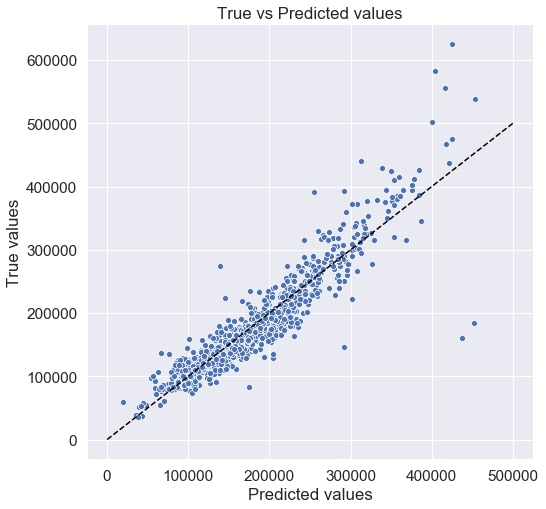

In [49]:
evaluate_preds(target_train, target_train_preds)

R2:	0.807
RMSE:	37632.156
MSE:	1416179180.94


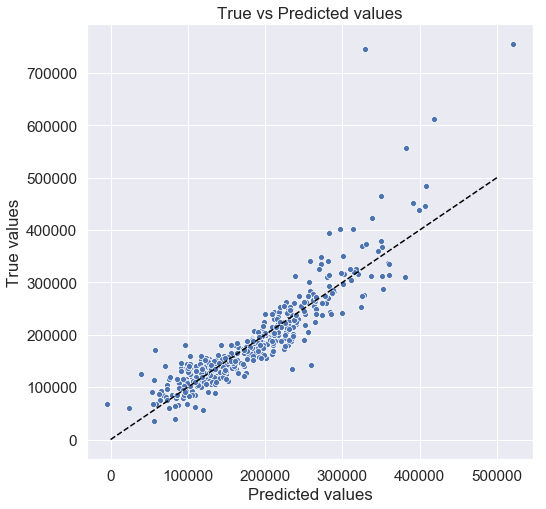

In [50]:
target_test_preds = lin_model.predict(data_test)

evaluate_preds(target_test, target_test_preds)

# Проверим, получим ли лучшее качество на более сложной модели

R2:	0.989
RMSE:	7942.998
MSE:	63091218.244


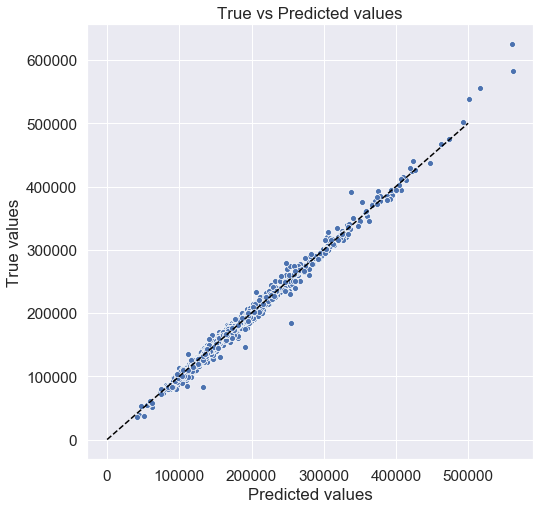

In [64]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(data_train, target_train)

target_train_preds = gb_model.predict(data_train)
evaluate_preds(target_train, target_train_preds)

R2:	0.885
RMSE:	29078.0
MSE:	845530080.703


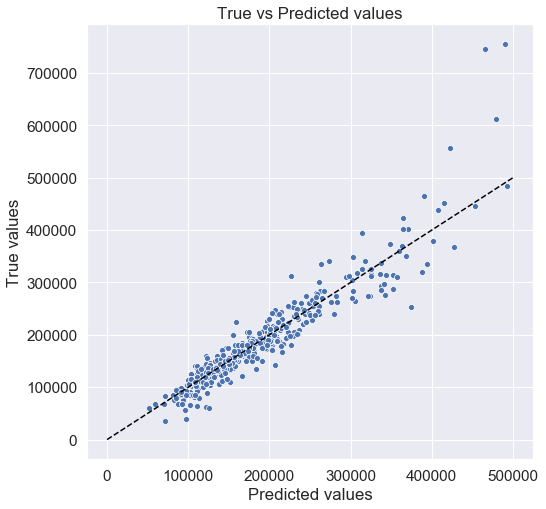

In [52]:
target_test_preds = gb_model.predict(data_test)
evaluate_preds(target_test, target_test_preds)

# Попробуем найти лучшие параметры

In [53]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2',  
                  cv=KFold(n_splits=5,   
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(data_train, target_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split...te=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 200, 400], 'max_depth': [3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [54]:
gs.best_params_

{'max_depth': 7, 'n_estimators': 400}

In [55]:
gs.best_score_

0.8620157416850682

In [56]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=400)

final_model.fit(data_train, target_train)

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

R2:	1.0
RMSE:	938.756
MSE:	881262.62


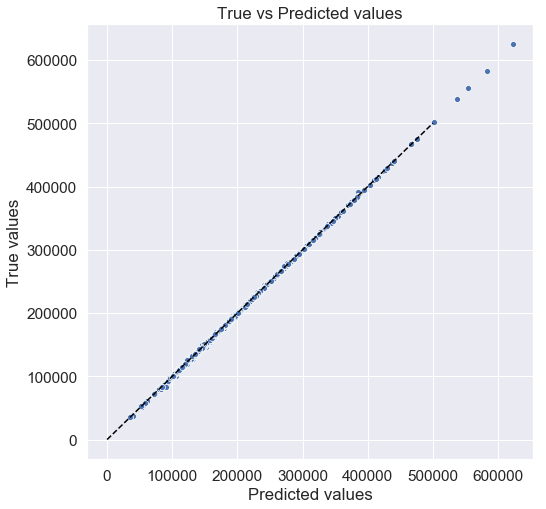

In [57]:
target_train_preds = final_model.predict(data_train)
evaluate_preds(target_train, target_train_preds)

R2:	0.89
RMSE:	28452.327
MSE:	809534922.448


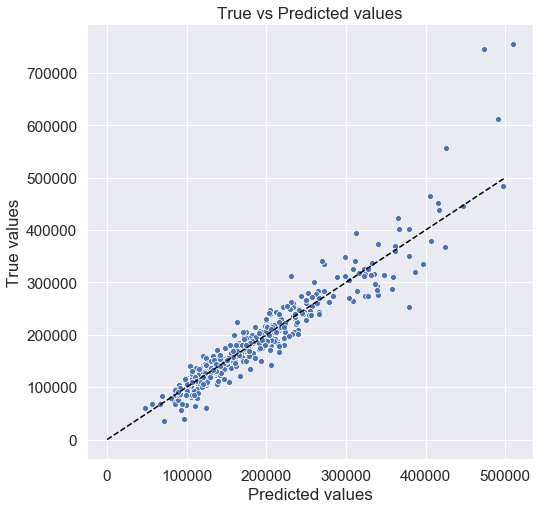

In [58]:
target_test_preds = final_model.predict(data_test)
evaluate_preds(target_test, target_test_preds, save=True)

# Построение предсказаний на test

In [59]:
final_test_preds = final_model.predict(data_test)
final_test_preds

array([137093.61811326, 323095.244719  , 119734.79450643, 168996.60784588,
       334925.21080941,  82337.56534492, 231292.8380056 , 152424.31111   ,
        85492.37764218, 125606.52008664, 147047.19240848, 122961.41944945,
       105391.2189649 , 201613.7329529 , 174362.61937057, 127086.91248265,
       198151.88102023, 127619.55403203, 122481.52981954, 199482.83379826,
       150675.37665925, 239549.61431012, 173335.41050234, 128310.22587603,
       195869.92809387, 172816.00730796, 199356.6098168 , 104943.15750914,
       174143.54543662, 216469.22063246, 125292.98348677, 264812.55064146,
       182250.03113447, 115021.89656393, 256299.51532286, 148716.26232154,
       128817.13666041, 207467.19452036, 288290.16808921, 113202.04410545,
       123837.48338409, 235204.92081067, 122060.15773505, 378880.88559747,
       124967.79907446, 122518.98201149, 113731.5015055 , 121848.93364564,
       415259.07152808, 137076.09145332, 119771.56853354, 194616.7121146 ,
       106712.58578119, 3